<a id='contents'><h1>Quantifying Centeredness of flower petal spots</h1></a>

Mimulus flowers often develop central spots on their petals, in addition to many other types of spot patterning. Let's develop a method for identifying and comparing spot centeredness in our images of spots. 

There are still a lot of issues with the process of digitizing polygons, many are not creating correctly. But here we'll forge a ahead and draw up a pipeline for analyzing the polygons that are digitizing without problems. 

<h3>Contents</h3>

[Recenter and scale petals and spots](#reSc)

[Examples of why this is hard:](#hard)  
  - [Concave polygons](#concave)
  - [Edge polygons](#edge)  
  
[Select polygons for scoring centeredness](#selPol)

<a id='reSC'><h3> 1 - Recenter and scale petals and spots</h3></a>

Let's look at one flower that digitized without problems, P416F1:

In [2]:
%% in matlab, setup work environment
imatlab_export_fig('print-png') %% sets inline plotting for jupyter instead of matlab's plotter
%% flower
fname = "P416F1";
%% working directory
wd="/Users/danthomas/Documents/speckling/center";
%% our petal structures with polygons are here, right now:
objDir="/Users/danthomas/Documents/speckling/make_polygons/matObjW_pol/";
%% they'll migrate to dougdir eventually...
%% jpegs are here
dougDir = "/Users/danthomas/Documents/speckling/dougRaster/Rotated_and_Cropped/";

In [3]:
cd(wd);
load(objDir + fname + ".mat") %% get the matlab struct for this flower
[a,b,c] = fileparts(Petals.fullName);
jpegName = char(dougDir + b + c); 

The flower looks like:

> In images.internal.initSize (line 71)
  In imshow (line 336)


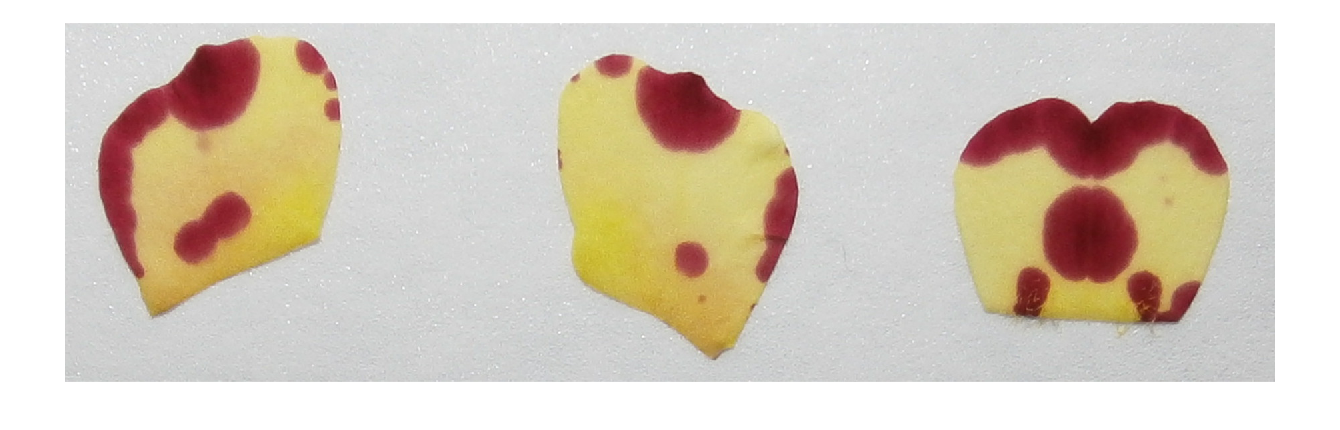

In [4]:
imshow(jpegName);

> In images.internal.initSize (line 71)
  In imshow (line 336)


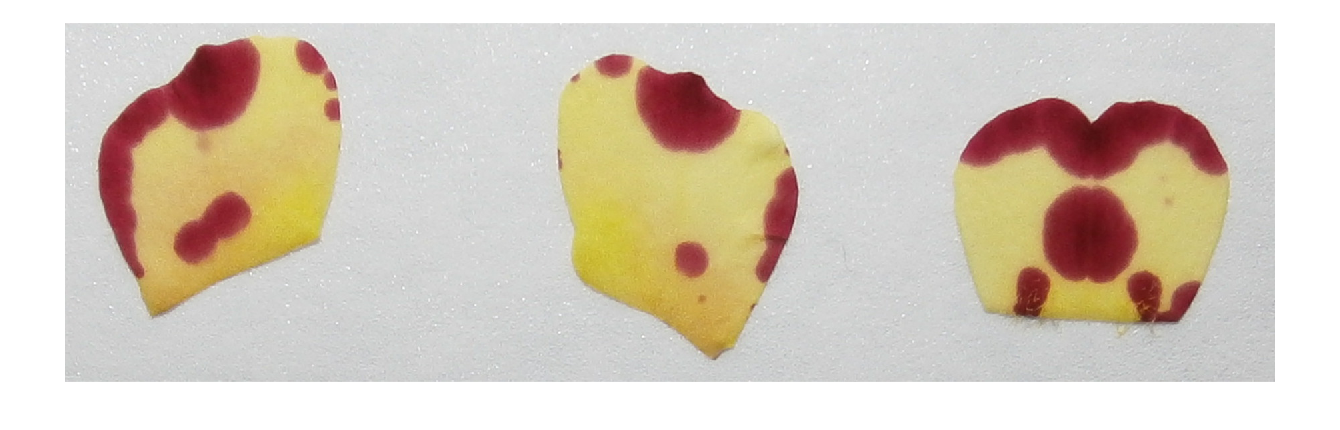

In [27]:
imshow(jpegName);

Let's standardize our petal to an area of 1, and recenter to the origin:

In [8]:
Petals.Polys.right.spots


ans = 

  1x4 polyshape array with properties:

    Vertices
    NumRegions
    NumHoles



In [11]:
petal = Petals.Polys.right.petal(1);
spots = Petals.Polys.right.spots;



bb = area(petal);
sc = 1/sqrt(bb);
cc = scale(petal, sc);
[cenX,cenY] = centroid(cc);
tPetal = translate(cc, -cenX, -cenY);
%% spots
counter = 1;
for i = spots;
    cc = scale(i, sc);
    tSpots(counter) = translate(cc, -cenX, -cenY);
    counter = counter + 1;
end;
%% maybe we can do that as an array?

area(petal); area(tPetal)
[CX CY] = centroid(tPetal)


ans =

    1.0000


CX =

     0


CY =

     0



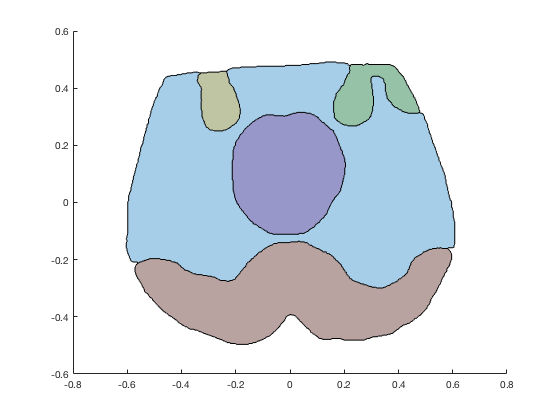

In [13]:
plot(tPetal);
hold on;
plot(tSpots)
hold off;

Kind of looks like a clown face. Note the axes, these polygons are now very tiny. This is a tiny clown face.

<h3><a id='hard'>2 - Examples of why this is hard</a></h3>

We'll try a very simple statistic for quantifying centeredness - average distance of polygon centroids from the center of the petal. However, some issues arise...

<a id="concave"><h4>Concave polygons</h4></a>

Centroids used in this way can be misleading for some polygons, such as polygons that follow the exteriour line of the petal. Often, with these the centroid is outside of the polygon itself and not really representative the bulk of the area within that polygon, in terms of centeredness:

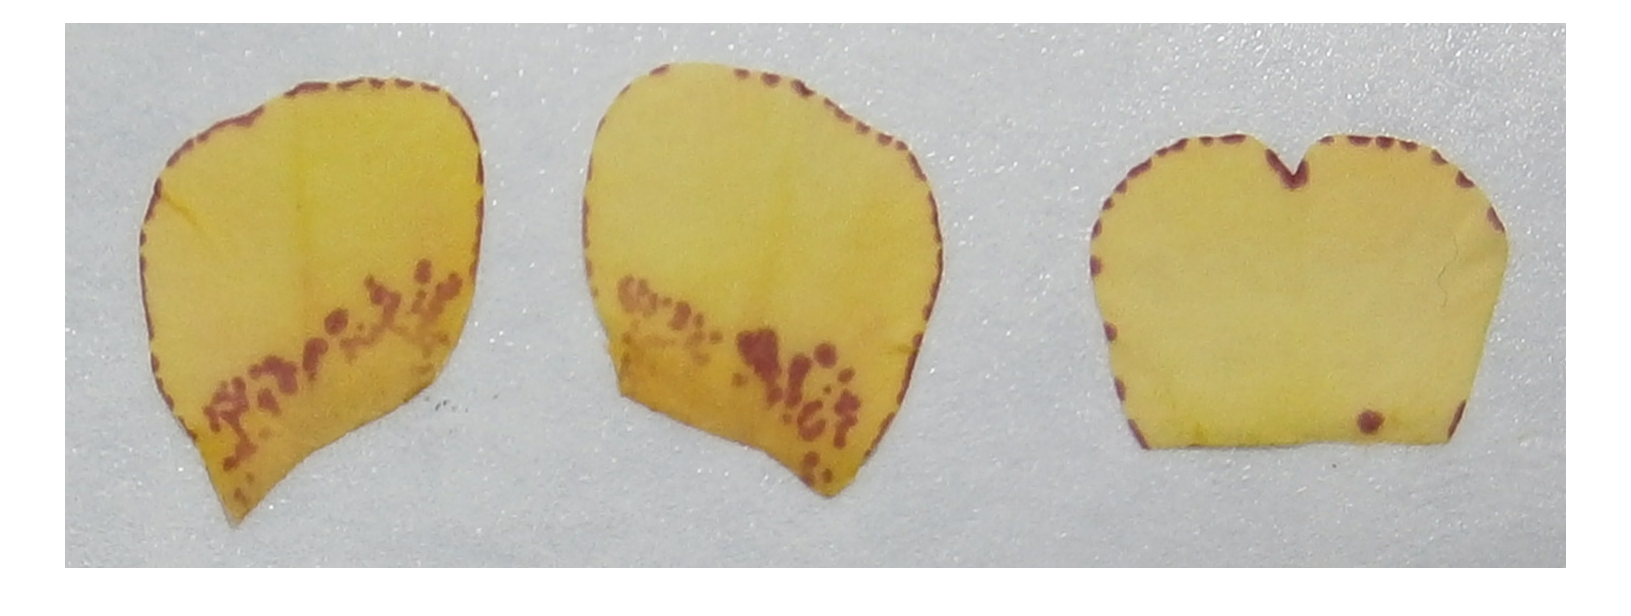

In [42]:
P371F2 = (objDir + "P371F2" + ".mat");
P371F2 = load(P371F2);
[a,b,c] = fileparts(P371F2.Petals.fullName);
jpegName = char(dougDir + b + c);
imshow(jpegName);

In [39]:
petal = P371F2.Petals.Polys.right.petal;
spot = P371F2.Petals.Polys.right.spots(1);
[cX, cY] = centroid(spot);
[CX, CY] = centroid(petal);

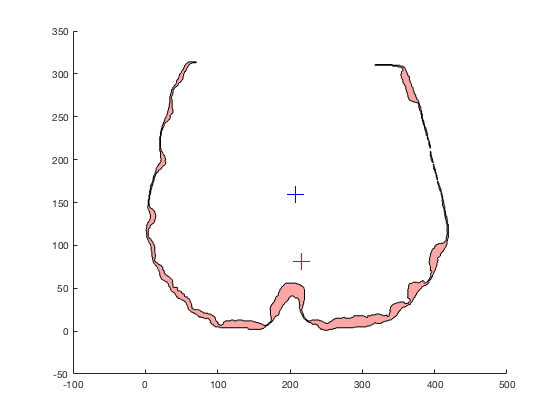

In [40]:
plot(spot, 'FaceColor','red');
hold on
plot(cX, cY, '+', 'MarkerSize', 15, 'Color', 'red');
plot(CX, CY, '+', 'MarkerSize', 15, 'Color', 'blue');
hold off

The blue cross represents the petal centroid, the red is the centroid of this ring-like polygon. This flower scores relatively high on our centeredness metric, because this major spot is concave, causing its center of gravity to be outside its polgyon borders, and because it is ~radially symmetric around the center. So its centroid falls close to the center of the petal. But this polygon is the exact opposite of centered - its spots exist as far from the center as they can!

Granted, this polygon happened because of errors in our digitization algorithms, and is actually many small spots on the real flower. But long, thin, edge-following spots aren't uncommon in the actual petals. And perhaps we can use this opportunity to account partially for the errors of digitization. 

Side note, if digitization had gone well, each of these spots' centroids would lie far from the center of the petal, and these numerous long distances would would overwhelm any centered spots of interest (discussed next). 

<a id='edge'><h4>Edge polygons</h4></a>

Related to the above, spots on the rim of the petal often cooccur with the centered spots that we are trying to detect. For instance, for the flower P378F2 has a really cool, somewhat centered spot on it's ventral petal that we'd like to score with our algorithm: 

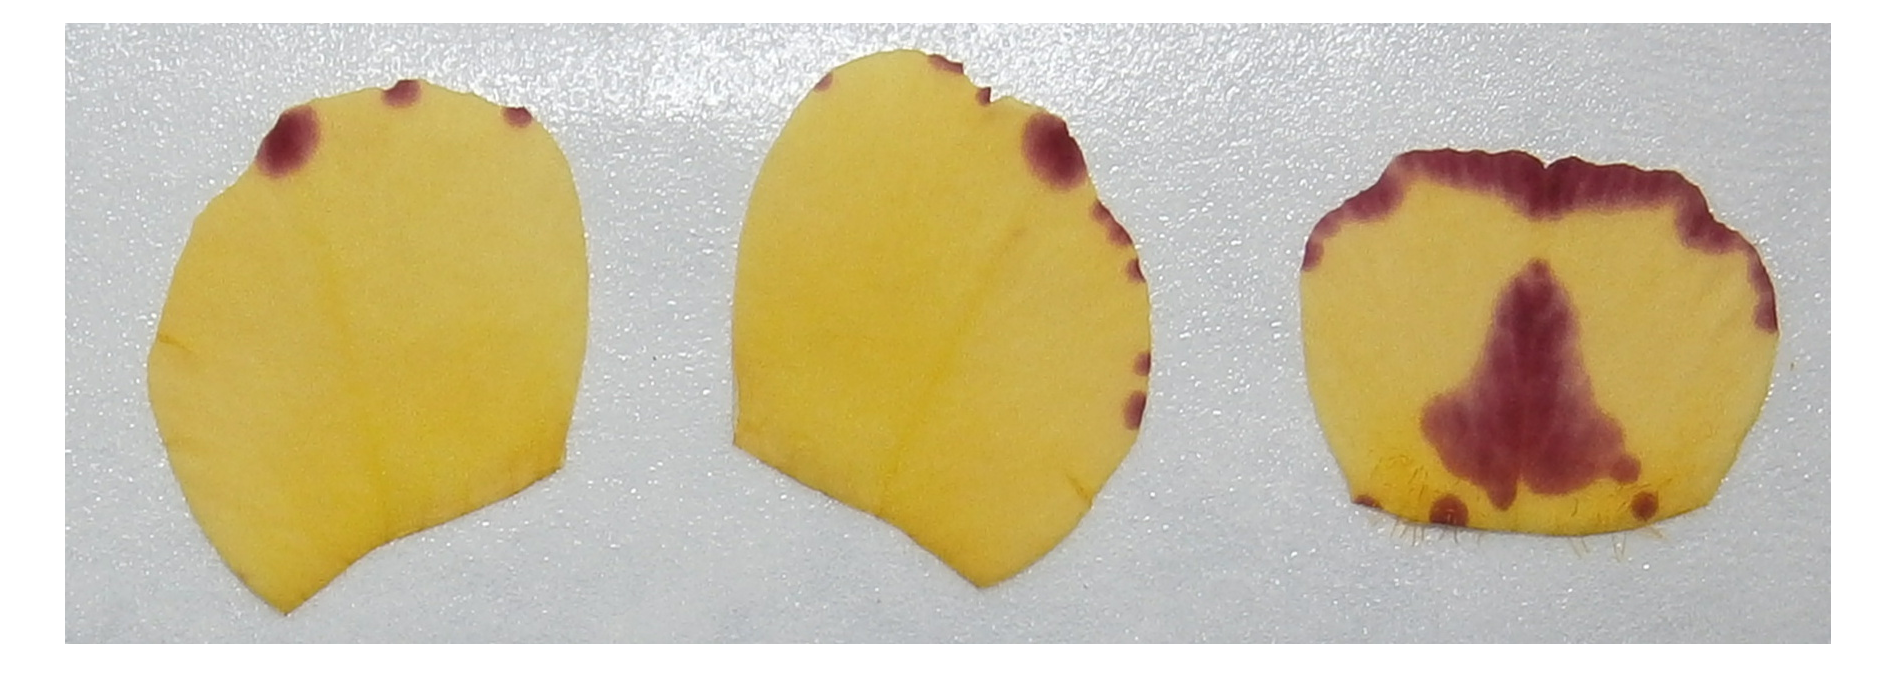

In [14]:
P378F2 = (objDir + "P378F2" + ".mat");
P378F2 = load(P378F2);
[a,b,c] = fileparts(P378F2.Petals.fullName);
jpegName = char(dougDir + b + c);
imshow(jpegName);

But it also has basal spots that are probably extensions of the nectar guides, and and a long, thin rim spot on the distal end of the petal. Both of these spots are interesting, and we hope to examine them a little using a "edginess" statistic. But we don't want them to bias our search for higly centered spots. 

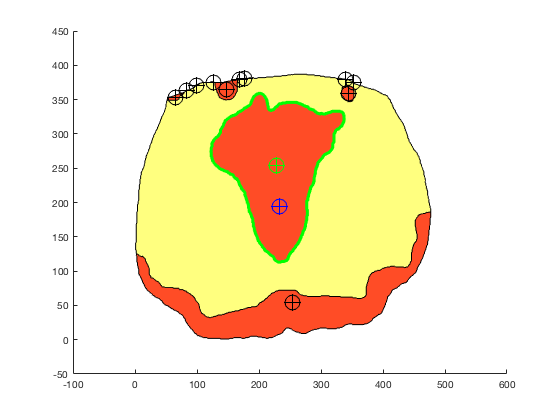

In [15]:
petal = P378F2.Petals.Polys.right.petal;
spot = P378F2.Petals.Polys.right.spots(3);
spots = P378F2.Petals.Polys.right.spots;

%% petal graphic:
plot(petal, "FaceColor","yellow", "FaceAlpha",0.5)
hold on;
plot(spots, "FaceColor","red","FaceAlpha",0.7)
plot(spot, "FaceColor","white","FaceAlpha",0, "EdgeColor",'green','Linewidth',3)

[CX, CY] = centroid(petal);
[cX, cY] = centroid(spot);
[csX, csY] = centroid(spots);

plot(CX, CY, 'o', 'MarkerSize', 15, 'Color', 'blue');
plot(CX, CY, '+', 'MarkerSize', 15, 'Color', 'blue');
plot(csX, csY, 'o', 'MarkerSize', 15, 'Color', 'black');
plot(csX, csY, '+', 'MarkerSize', 15, 'Color', 'black');
plot(cX, cY, 'o', 'MarkerSize', 15, 'Color', 'green');
plot(cX, cY, '+', 'MarkerSize', 15, 'Color', 'green');

The blue point is our petal centroid. The green point is the centroid of just our non-edge spot (green outline), possibly the only polygon we care about in the petal for this statistic. The black centroids are the edge-associated spots' centroids. If we don't correct for rim spots, these distances will quickly outweigh the relatively centered non-edge spot of interest.

So we need to remove these edge-based polygons from consideration, while we hunt for our centered polyons. 

<h3><a id='selPol'>3 - Select polygons for scoring centeredness</a></h3>

To exclude these edge polygons, we'll create a margin that is ~25% the area of our petal. Start with the standardization protocol:

In [16]:
%% standardize:
bb = area(petal);
sc = 1/sqrt(bb);
cc = scale(petal, sc);
[cenX,cenY] = centroid(cc);
tPetal = translate(cc, -cenX, -cenY);
%% spots
counter = 1;
for i = spots;
    cc = scale(i, sc);
    tSpots(counter) = translate(cc, -cenX, -cenY);
    counter = counter + 1;
end;
tSpot = tSpots(3);

We want a +/- standard amount of every petal incorporated into its margin of exclusion. So if we want to generate a polygon that incorporates the outer 25% of our petal shape, something like this should get us close:

In [17]:
t = 0;
perc = 0;
while perc < .25;
    disp("t = " + t)
    t = t - 0.001;
    middlePoly = polybuffer(tPetal,t);
    edgePoly = subtract(tPetal, middlePoly);
    perc = area(edgePoly) / area(tPetal);
    disp("% = " + perc)
end;
t=t+0.001 %% back up
middlePoly = polybuffer(tPetal,t);
edgePoly = subtract(tPetal, middlePoly);

t = 0
% = 0.0038978
t = -0.001
% = 0.0077735
t = -0.002
% = 0.011627
t = -0.003
% = 0.015459
t = -0.004
% = 0.019271
t = -0.005
% = 0.023061
t = -0.006
% = 0.02683
t = -0.007
% = 0.03058
t = -0.008
% = 0.034312
t = -0.009
% = 0.038027
t = -0.01
% = 0.041727
t = -0.011
% = 0.045413
t = -0.012
% = 0.049087
t = -0.013
% = 0.052748
t = -0.014
% = 0.056398
t = -0.015
% = 0.060037
t = -0.016
% = 0.063666
t = -0.017
% = 0.067285
t = -0.018
% = 0.070894
t = -0.019
% = 0.074495
t = -0.02
% = 0.078086
t = -0.021
% = 0.081668
t = -0.022
% = 0.085242
t = -0.023
% = 0.088807
t = -0.024
% = 0.092365
t = -0.025
% = 0.095914
t = -0.026
% = 0.099455
t = -0.027
% = 0.10299
t = -0.028
% = 0.10651
t = -0.029
% = 0.11003
t = -0.03
% = 0.11354
t = -0.031
% = 0.11705
t = -0.032
% = 0.12054
t = -0.033
% = 0.12403
t = -0.034
% = 0.12751
t = -0.035
% = 0.13099
t = -0.036
% = 0.13445
t = -0.037
% = 0.13791
t = -0.038
% = 0.14137
t = -0.039
% = 0.14481
t = -0.04
% = 0.14825
t = -0.041
% = 0.15168
t = -0.042
% = 0

This final t is approximately the thickness of the margin needed to get the outer 25% area of our petal:

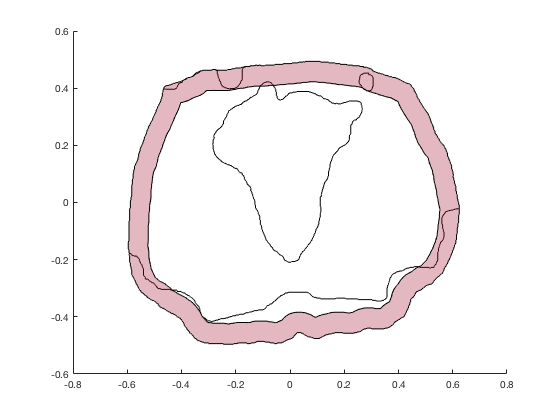

In [18]:
hold off;
plot(tPetal)
hold on;
plot(tSpots)
plot(edgePoly, "FaceAlpha",0.3)

We can then check the amount of overlap of this margin onto our polygons, and use this to discard edge polygons from our centeredness measurements. We'll start by saying that any spot that is 50% or more inside this edge margin are considered edge spots, and are not of interest for the centeredness statistic. 

This number, and the %25 area size of the margin itself can be tweaked.

In [19]:
allInEdge = intersect(tSpots, edgePoly); 
area(allInEdge)./area(tSpots) %% how much of each of our polygons are in this margins?
notEdge = area(allInEdge)./area(tSpots) < 0.5 %% which do we keep?


ans =

  Columns 1 through 7

    0.7449    1.0000    0.0024    1.0000    1.0000    1.0000    1.0000

  Columns 8 through 12

    1.0000    0.9989    1.0000    1.0000    1.0000


notEdge =

  1x12 logical array

   0   0   1   0   0   0   0   0   0   0   0   0



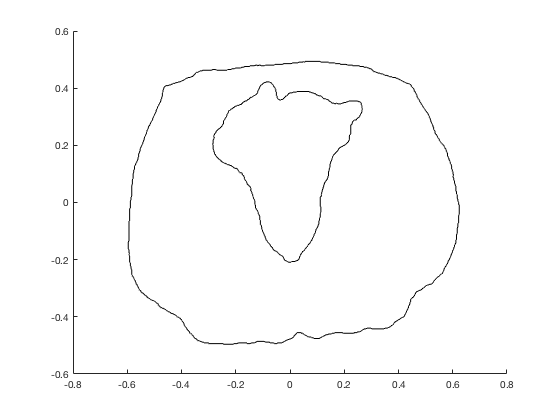

In [48]:
imatlab_export_fig('print-png')
plot(tSpots(notEdge),'FaceColor','red','FaceAlpha',0.1); 
hold on;
h = plot(tPetal, 'FaceColor','red', 'FaceAlpha', 0.3);
hold off;

Huh, my color plotter is failing, not sure why. Seems to just be the plotter for jupyter...

Regardless, we can see that we've removed the edge polygons. What, then, is our centeredness statistic for this petal?

In [51]:
cSpots = tSpots(notEdge);
[cX, cY] = centroid(cSpots);

X = [0 cX];
Y = [0 cY];

pdist2(X, Y)


ans =

    0.1679



Okay. Hard to really know what this means until we compare it to the other petals and flowers. Time to make a pipeline.